## Homework #2 - Adv Machine Learning
Cheng Man  
03/04/2020

### Import packages and dataset first

In [0]:
# Loading packages
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [0]:
# Unzip the dataset file
!unzip brain_tumor_dataset.zip

In [0]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# Load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y98.JPG', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y38.jpg', 'brain_tumor_dataset/yes/Y253.JPG', 'brain_tumor_dataset/yes/Y108.jpg', 'brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y20.jpg', 'brain_tumor_dataset/yes/Y82.jpg', 'brain_tumor_dataset/yes/Y153.jpg', 'brain_tumor_dataset/yes/Y3.jpg', 'brain_tumor_dataset/yes/Y44.JPG', 'brain_tumor_dataset/yes/Y257.jpg', 'brain_tumor_dataset/yes/Y29.jpg', 'brain_tumor_dataset/yes/Y22.jpg', 'brain_tumor_dataset/yes/Y168.jpg', 'brain_tumor_dataset/yes/Y14.jpg', 'brain_tumor_dataset/yes/Y112.JPG', 'brain_tumor_dataset/yes/Y113.JPG', 'brain_tumor_dataset/yes/Y103.jpg', 'brain_tumor_dataset/yes/Y34.jpg', 'brain_tumor_dataset/yes/Y104.jpg', 'brain_tumor_dataset/yes/Y249.JPG', 'brain_tumor_dataset/yes/Y1.jpg', 'brain_tumor_dataset/yes/Y120.JPG', 'brain_tumor_dataset/yes/Y187.jpg', 'brain_tumor_dataset/yes/Y156.JPG', 'brain_tumor_dataset/yes/Y116.J

In [0]:
# Preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')

# Report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


### Creating X set

In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [0]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

### Create y set

In [0]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


### 1. Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

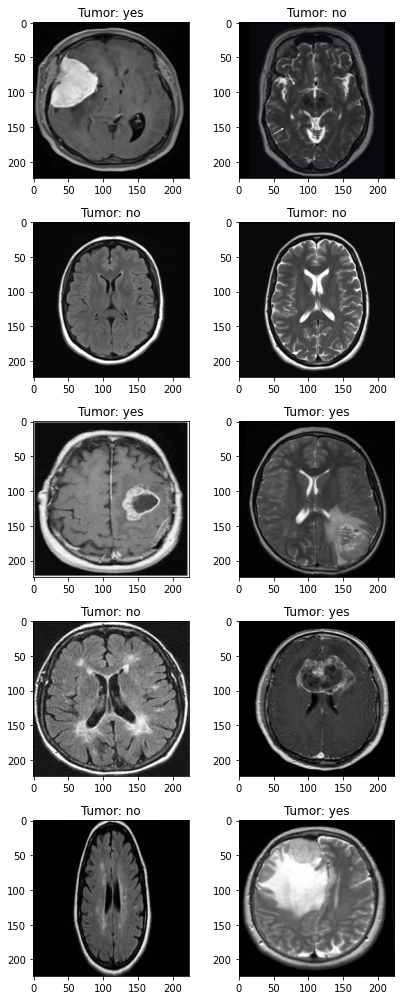

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(6,14)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

### 2. Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

> When building a model like this, that can judge a brain X-ray figure whether having or tumor or not, can be helpful in two kinds of aspects.
1. First, for doctors, this model helps them to archive these files easier. As this model, though it is simple that can only distinguish having tumor or not. However, keep upgrade the model, can even help doctors seperate different kinds of tumors. This process will be helpful for their researcheses or diagnosis.
2. Second, for patients, since they have less professional knowledge towards their X-ray photos, using this model can help them find out whether their X-ray photos tell them they have a brain tumor or not. This can be a self-diagnosis process. Further, if upgrade the model, people can even find out the most likely situations. Base on the other patient's treatment and experiences, they can get more information and be fully prepared.

### 3. Run at least three prediction models to try to predict brain tumor MRI images well. 

In [0]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X, y, random_state = 42, stratify = y)

#### 3.1 Model #1: a basic convnet model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): 
      opt=SGD(lr=.01)

      model1 = Sequential()
      model1.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Flatten())
      model1.add(Dense(2, activation='sigmoid')) 

      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', 
                           verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                                verbose=1, factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs                                                

      model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model1.fit(X_train, y_train, epochs = 10, 
                 verbose=1, validation_data=(X_test, y_test), callbacks=[mc, red_lr])

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.4603
Epoch 00001: val_accuracy improved from -inf to 0.39062, saving model to best_model.h5
6/6 [==============================] - 1s 159ms/step - loss: 0.8740 - accuracy: 0.4603 - val_loss: 0.6918 - val_accuracy: 0.3906 - lr: 0.0100
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.3862
Epoch 00002: val_accuracy improved from 0.39062 to 0.40625, saving model to best_model.h5
6/6 [==============================] - 1s 146ms/step - loss: 0.6865 - accuracy: 0.3862 - val_loss: 0.6880 - val_accuracy: 0.4062 - lr: 0.0100
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.4021
Epoch 00003: val_accuracy improved from 0.40625 to 0.45312, saving model to best_model.h5
6/6 [==============================] - 1s 145ms/step - loss: 0.6835 - accuracy: 0.4021 - val_loss: 0.6855 - val_accuracy: 0.4531 - lr: 0.0100
Epoch 4/10
6/6 [===============

In [0]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions = model1.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0
 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [0]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.765625,0.730866,0.78125,0.721538,0,0,0,0


#### 3.2 Model #2: a more complex convnet model

In [0]:
with tf.device('/device:GPU:0'):
  opt = Adam(learning_rate=0.01)
  
  model2 = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='sigmoid')
      ])
  red_lr= ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                            verbose=1, factor=0.5, min_lr = 0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, 
             epochs = 5, verbose=1, validation_data=(X_test,y_test), callbacks=[red_lr])

Epoch 1/5
6/6 [==============================] - 0s 65ms/step - loss: 0.6790 - accuracy: 0.5608 - val_loss: 0.6705 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 2/5
6/6 [==============================] - 0s 42ms/step - loss: 0.6161 - accuracy: 0.7249 - val_loss: 0.6216 - val_accuracy: 0.6875 - lr: 0.0100
Epoch 3/5
6/6 [==============================] - 0s 43ms/step - loss: 0.5379 - accuracy: 0.7513 - val_loss: 0.7231 - val_accuracy: 0.7188 - lr: 0.0100
Epoch 4/5
6/6 [==============================] - 0s 40ms/step - loss: 0.4943 - accuracy: 0.7725 - val_loss: 0.5911 - val_accuracy: 0.7031 - lr: 0.0100
Epoch 5/5
6/6 [==============================] - 0s 42ms/step - loss: 0.4441 - accuracy: 0.7884 - val_loss: 0.6033 - val_accuracy: 0.7344 - lr: 0.0100


In [0]:
raw_predictions = model2.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0
 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes']


In [0]:
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.734375,0.702326,0.730676,0.695897,0,0,0,0


#### 3.3 Model #3: transfer learning convnet model

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG16
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

model3 = Sequential([
   base_model,
   GlobalAveragePooling2D(),
   Dense(2, activation="sigmoid")
])

opt = Adam(learning_rate=0.01)

with tf.device('/device:GPU:0'): 
  model3.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics=['accuracy'])
  red_lr= ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                            verbose=1, factor=0.5, min_lr = 0.001)
  model3.fit(X_train, y_train,
             epochs = 25, verbose=1, validation_data=(X_test, y_test), callbacks=[red_lr])

Epoch 1/25
6/6 [==============================] - 1s 126ms/step - loss: 0.7708 - accuracy: 0.5397 - val_loss: 0.6787 - val_accuracy: 0.6094 - lr: 0.0100
Epoch 2/25
6/6 [==============================] - 1s 100ms/step - loss: 0.6264 - accuracy: 0.6138 - val_loss: 0.6413 - val_accuracy: 0.7188 - lr: 0.0100
Epoch 3/25
6/6 [==============================] - 1s 101ms/step - loss: 0.6092 - accuracy: 0.7143 - val_loss: 0.6130 - val_accuracy: 0.6406 - lr: 0.0100
Epoch 4/25
6/6 [==============================] - 1s 100ms/step - loss: 0.5521 - accuracy: 0.6878 - val_loss: 0.5889 - val_accuracy: 0.7031 - lr: 0.0100
Epoch 5/25
6/6 [==============================] - 1s 101ms/step - loss: 0.5028 - accuracy: 0.7619 - val_loss: 0.5592 - val_accuracy: 0.7812 - lr: 0.0100
Epoch 6/25
6/6 [==============================] - 1s 102ms/step - loss: 0.4448 - accuracy: 0.8201 - val_loss: 0.5413 - val_accuracy: 0.7812 - lr: 0.0100
Epoch 7/25
6/6 [==============================] - 1s 101ms/step - loss: 0.4097 - a

In [0]:
raw_predictions = model3.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0
 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1]
['yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes']


In [0]:
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.875,0.868718,0.868718,0.868718,0,0,0,0


In [0]:
# add metrics to submittable object
modelevalobject=model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

modelevalobject# add metrics to submittable object

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.875,0.868718,0.868718,0.868718,0,0,0,0


#### 3.4 Discussion

---

The best model I created is the Model3. I used VGG16 as the base model, added a pooling layer and a sigmoid function to get the binary result. Also, I tried to add a learning rate reduce function, `red_lr` in the above section, which allow me to reduce the learning rate in the `.fit` process.

Here are some relevant hyper-parameter values:  

1.  Optimizer  
The optimizer I chose is `Adam()`. From the documentation, "*Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments*". I set the basic learning rate in the optimizer function as well.

2.  Learning rate
The basic learning rate I set is 0.01. As I mentioned, in `red_lr` I set a learning rate reduce principle. If after 4 epochs the `val_accuracy` fails to improve, the learning rate will be divided by 2. The minimal learning rate is set to 0.001 in order to avoid it getting too low.

3.  Epochs
I set the epochs to 25. The `epochs` means the number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. 

### 4. Submit the best model

In [0]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model3, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [0]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = ""
password = ""

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [0]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")

### 5. Get the leaderboard and import the best model

In [0]:
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = ""
password = ""

In [0]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,4.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,5.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
7,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,9,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
8,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,10,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
6,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
5,0.764706,0.757143,0.780303,0.756944,0,0,0,0,username1,7,7.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


#### 5.1 Print the best model's config and optimizer

In [0]:
# Import and print model details from leaderboard
model_accuracy = leaderboard.loc[15,'accuracy']
model_config = leaderboard.loc[15,'model_config'] # model details best model (i.e.-row #1)
model_optim_config = leaderboard.loc[15,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_accuracy)
print(model_config)
print(model_optim_config)

0.9411764705882352
backend: tensorflow
class_name: Sequential
config:
  build_input_shape: !!python/object/apply:tensorflow.python.framework.tensor_shape.TensorShape
  - - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [null]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [3]
  layers:
  - class_name: Model
    config:
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      input_layers:
      - [input_17, 0, 0]
      layers:
      - class_name: InputLayer
        config:
          batch_input_shape: !!python/tuple [null, 224, 224, 3]
          dtype: float32
          name: input_17
          ragged: false
          sparse: false
        inbound_nodes: []
        name: input_17
      - class_name: Conv2D
        config:
          activation: linear
  

#### 5.2 Print best model's structure and compare to my own model

In [0]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model_best = model_from_yaml(model_config)
model_best.summary() #Best model summary

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 32,738
Non-trainable params: 21,774,144
_________________________________________________________________


In [0]:
model3.summary() #My best model summary

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
print(model_optim_config) #Best model optimizer

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [0]:
print(leaderboard.loc[16,'model_optim_config']) #This is my own model optimizer

{'name': 'Adam', 'learning_rate': 0.01, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


##### 5.2.1 Structure

---

Compared to my best model, the leaderboard model used `Inception v3` model as its base model, compared to my selection of `VGG16`.  
Also, I used 25 epochs while the best model has 16 epochs.


##### 5.2.2 Optimizer

---

For optimizer selection, we both chose `Adam`, but the best model used 0.001 learning rate, while I chose 0.01 with a learning rate deduction.

### 5.3 Fit the best model

In [0]:
with tf.device('/device:GPU:0'): 
  model_best.compile(optimizer = Adam(learning_rate=0.001),
                     loss= 'categorical_crossentropy', metrics=['accuracy'])
  model_best.fit(X_train, y_train, epochs=16, verbose=1, validation_data=(X_test, y_test))

Epoch 1/16
6/6 [==============================] - 2s 325ms/step - loss: 0.5625 - accuracy: 0.7354 - val_loss: 0.7046 - val_accuracy: 0.6562
Epoch 2/16
6/6 [==============================] - 1s 127ms/step - loss: 0.5901 - accuracy: 0.7513 - val_loss: 0.6172 - val_accuracy: 0.7188
Epoch 3/16
6/6 [==============================] - 1s 130ms/step - loss: 0.5567 - accuracy: 0.7672 - val_loss: 0.8617 - val_accuracy: 0.6094
Epoch 4/16
6/6 [==============================] - 1s 127ms/step - loss: 0.5689 - accuracy: 0.7460 - val_loss: 0.8421 - val_accuracy: 0.6094
Epoch 5/16
6/6 [==============================] - 1s 127ms/step - loss: 0.5679 - accuracy: 0.7619 - val_loss: 0.6742 - val_accuracy: 0.6562
Epoch 6/16
6/6 [==============================] - 1s 129ms/step - loss: 0.5601 - accuracy: 0.7778 - val_loss: 0.6206 - val_accuracy: 0.6562
Epoch 7/16
6/6 [==============================] - 1s 128ms/step - loss: 0.5511 - accuracy: 0.7937 - val_loss: 0.6218 - val_accuracy: 0.7188
Epoch 8/16
6/6 [====

In [0]:
raw_predictions = model_best.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [0]:
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.71875,0.639549,0.789899,0.647179,0,0,0,0
